In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
pd.plotting.register_matplotlib_converters()

In [2]:
df = pd.read_parquet("../data/scifi_fantasy.parquet")

In [3]:
df.ratings_count.astype(np.int64).head()

0    3844
1    2627
2    5141
3    2178
4    6557
Name: ratings_count, dtype: int64

<Axes: xlabel='ratings_count', ylabel='Density'>

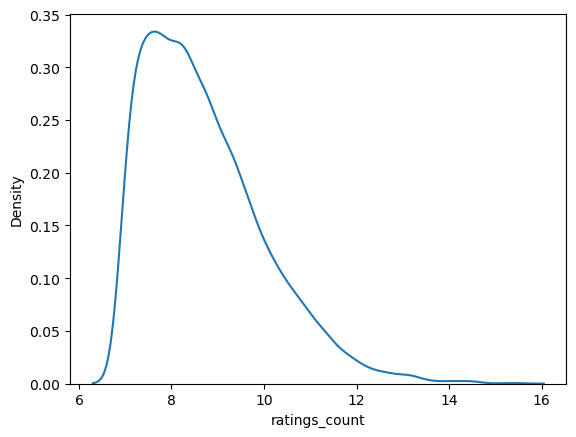

In [11]:
sns.kdeplot(x=np.log1p(df.ratings_count.astype(np.int64)))

In [5]:
df.columns

Index(['books_count', 'reviews_count', 'original_publication_month',
       'default_description_language_code', 'text_reviews_count',
       'best_book_id', 'original_publication_year', 'original_title',
       'rating_dist', 'default_chaptering_book_id', 'original_publication_day',
       'original_language_id', 'ratings_count', 'media_type', 'ratings_sum',
       'work_id', 'tags', 'isbn', 'text_reviews_count_right', 'series',
       'country_code', 'language_code', 'popular_shelves', 'asin', 'is_ebook',
       'average_rating', 'kindle_asin', 'similar_books', 'description',
       'format', 'link', 'authors', 'publisher', 'num_pages',
       'publication_day', 'isbn13', 'publication_month', 'edition_information',
       'publication_year', 'url', 'image_url', 'ratings_count_right',
       'work_id_right', 'title', 'title_without_series'],
      dtype='object')

In [17]:
(df.asin == 'B00OM9OKEC').any()

np.False_

In [12]:
awards = pd.read_json("../data/awards.json", lines=True)
awards["year"] = pd.to_datetime(awards["year"], format="%Y")
awards.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   title    1575 non-null   object        
 1   year     1575 non-null   datetime64[ns]
 2   award    1575 non-null   object        
 3   result   1575 non-null   object        
 4   nominee  1575 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 61.7+ KB


In [13]:
merged_awards = awards.merge(df, left_on="title", right_on="title", how="left")
merged_awards[merged_awards.isbn.isna()]

,title,year,award,result,nominee,books_count,reviews_count,original_publication_month,default_description_language_code,text_reviews_count,...,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,ratings_count_right,work_id_right,title_without_series
1,(R)evolution,2016-01-01,Philip K Dick Award,finalist,PJ Manney,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,...And Call Me Conrad,1966-01-01,Hugo Awards,winner (tie),Roger Zelazny,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,...And Having Writ...,1979-01-01,John W Campbell Memorial Award,honorable mention,Donald R. Bensen,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/ Slant,1998-01-01,John W Campbell Memorial Award,second place,Greg Bear,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2010: Odyssey Two,1983-01-01,Hugo Awards,nomination,Arthur C. Clarke,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1569,Zero History,2011-01-01,John W Campbell Memorial Award,finalist,William Gibson,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1571,Zig Zag,2008-01-01,John W Campbell Memorial Award,finalist,Jose Carlos Somoza,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1572,Zoe's Tale,2009-01-01,Hugo Awards,nomination,John Scalzi,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1574,Ægypt,1988-01-01,World Fantasy Awards,nomination,John Crowley,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
def make_publication_date(row):
    if row.map(lambda x: x == '').any():
        return pd.NaT
    return pd.to_datetime(row.astype(str).str.cat(sep='-'))

In [148]:
builtin_features = ["title_without_series", "average_rating", "ratings_count", "text_reviews_count", "num_pages", "publisher", "publication_year"]
engineered_features = ["in_series", "publisher_count", "publication_date"]
features = builtin_features + engineered_features

books = df[language_mask].copy()

books["num_pages"] = books.num_pages.replace({'': pd.NA}).astype(pd.Float64Dtype())
books["in_series"] = books["series"].apply(lambda x: len(x) > 0).astype(pd.Int64Dtype())

publisher_counts = books["publisher"].value_counts()
# missing publisher for later imputing
publisher_counts[''] = np.nan
books["publisher_count"] = books["publisher"].map(publisher_counts)

books["publication_date"] = books[["publication_year", "publication_month", "publication_day"]].apply(make_publication_date, axis='columns')

books = books[features]
books.head()

,title_without_series,average_rating,ratings_count,text_reviews_count,num_pages,publisher,publication_year,in_series,publisher_count,publication_date
1,"Fortune's Pawn (Paradox, #1)",3.96,1023,86,340.0,,,1,NaN,NaT
2,Peter Nimble and His Fantastic Eyes (Peter Nim...,4.04,6049,890,400.0,Amulet Books,2011,1,16.0,2011-08-01
3,"Collide (Collide, #1)",3.86,5125,346,360.0,,2011,1,NaN,2011-06-12
4,The Disappearances,4.13,1092,325,388.0,HMH Books for Young Readers,2017,0,89.0,2017-07-04
5,A Quick Bite (Argeneau #1),3.91,32140,1223,360.0,Avon,2005,1,61.0,2005-10-25


<Axes: xlabel='num_pages', ylabel='Density'>

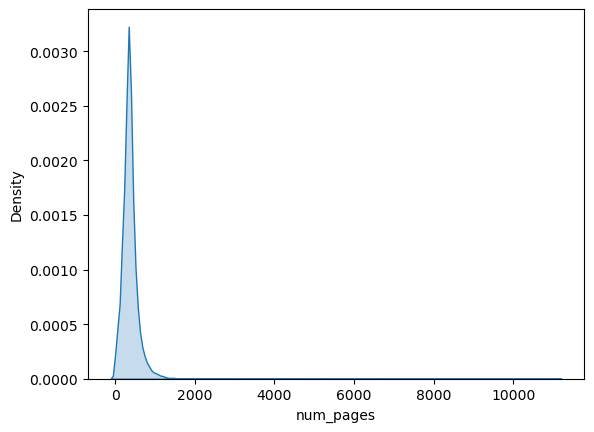

In [119]:
sns.kdeplot(books.num_pages, fill=True)

<Axes: xlabel='num_pages', ylabel='average_rating'>

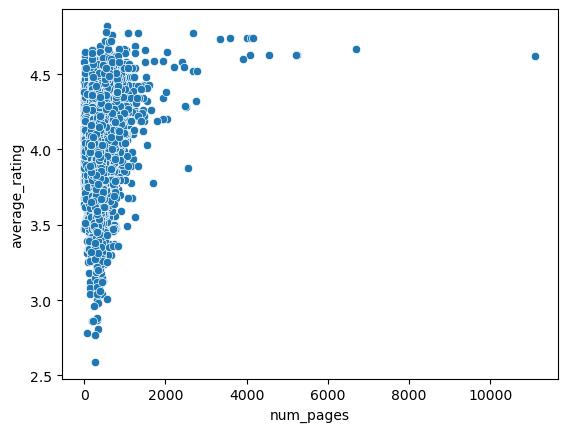

In [124]:
sns.scatterplot(x="num_pages", y="average_rating", data=books)

In [11]:
df.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

In [5]:
df_works = pd.read_json("../data/raw/goodreads_book_works.json.gz", lines=True)
df_works.columns

Index(['books_count', 'reviews_count', 'original_publication_month',
       'default_description_language_code', 'text_reviews_count',
       'best_book_id', 'original_publication_year', 'original_title',
       'rating_dist', 'default_chaptering_book_id', 'original_publication_day',
       'original_language_id', 'ratings_count', 'media_type', 'ratings_sum',
       'work_id'],
      dtype='object')

In [18]:
df_combined = pd.merge(df, df_works, on='work_id').set_index('book_id')

In [23]:
len(set.difference(set(df_combined.best_book_id), set(df_combined.index)))

147

In [87]:
df_combined[df_combined.book_id == df_combined.iloc[3].best_book_id].work_id == df_combined.work_id.iloc[3]

3    True
Name: work_id, dtype: bool

In [29]:
def flatten_to_work(row):
    first_row = row.iloc[0]
    best_book_id = first_row.best_book_id
    if best_book_id in row.index:
        reference_row = row.loc[best_book_id]
    else:
        reference_row = first_row

    return pd.DataFrame({
        'Title': [reference_row.original_title],
        'PubYear': [reference_row.original_publication_year],
        'author_ids': [[author['author_id'] for entry in row.authors for author in entry]],
        'popular_shelves': [[shelf for entry in row.popular_shelves for shelf in entry]],
        'description': reference_row.description,
        'num_pages': reference_row.num_pages
    })

df_collapsed = df_combined.groupby('work_id').apply(flatten_to_work, include_groups=False)

In [30]:
df_collapsed.head()

,,Title,PubYear,author_ids,popular_shelves,description,num_pages
work_id,,,,,,,
423,0,The Forever War,1974,"[12476, 12476, 4763, 12476, 4763, 12476]","[{'count': '53676', 'name': 'to-read'}, {'coun...","Series Info:\nThis is the first part of the ""F...",278
466,0,The Melancholy Death of Oyster Boy and Other S...,1997,"[5773, 5773]","[{'count': '12411', 'name': 'to-read'}, {'coun...",From breathtaking stop-action animation to bit...,115
505,0,Sorcery and Cecelia or: The Enchanted Chocolat...,1988,"[36122, 36175]","[{'count': '12090', 'name': 'to-read'}, {'coun...",A great deal is happening in London and the co...,326
551,0,The Great Dune Trilogy,1977,[58],"[{'count': '13540', 'name': 'to-read'}, {'coun...","Herbert's evocative, epic tales are set on the...",910
555,0,The Renegades of Pern,1989,[26],"[{'count': '984', 'name': 'to-read'}, {'count'...","As long as the people of Pern could remember, ...",384


In [31]:
df_collapsed.describe()

,Title,PubYear,author_ids,popular_shelves,description,num_pages
count,12165,12165,12165,12165,12165,12165
unique,9991,196,5157,12165,11684,932
top,,2012,[8685],"[{'count': '53676', 'name': 'to-read'}, {'coun...",,
freq,1916,988,71,1,471,983


In [32]:
df_collapsed.count()

Title              12165
PubYear            12165
author_ids         12165
popular_shelves    12165
description        12165
num_pages          12165
dtype: int64